## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
/ WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The follow

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(5, 6):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:28<00:00,  3.72it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_5"])
layer_hs_array.shape

(10000, 267264)

## Layer 5 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 4.15 s
Outer iteration 0 / 10
  Iteration 19 (11.40 s, search 7.51 s): objective=2139.1 imbalance=1.305 nsplit=0        
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (22.79 s, search 15.04 s): objective=2148.34 imbalance=1.252 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (34.19 s, search 22.54 s): objective=2145.48 imbalance=1.035 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (45.59 s, search 30.07 s): objective=2147.31 imbalance=1.118 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (57.00 s, search 37.58 s): objective=2142.13 imbalance=1.571 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (68.38 s, search 45.10 s): objective=2140.59 imbalance=1.489 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (79.78 s, search 52.60 s): objective=2141.57 im

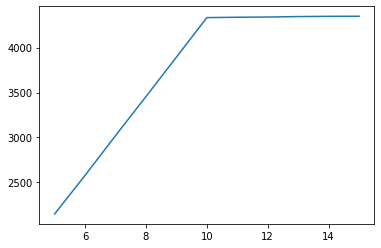

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.28 s
Outer iteration 0 / 10
  Iteration 19 (22.54 s, search 14.88 s): objective=4295.93 imbalance=1.982 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (45.18 s, search 29.78 s): objective=4321.2 imbalance=1.527 nsplit=0        
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (67.90 s, search 44.70 s): objective=4296.94 imbalance=1.858 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (90.53 s, search 59.58 s): objective=4333.63 imbalance=1.272 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (113.09 s, search 74.45 s): objective=4316.11 imbalance=2.205 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (135.65 s, search 89.33 s): objective=4295.39 imbalance=2.147 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (158.50 s, search 104.33 s): objective=4322.6 imba

4333.7138671875

In [15]:
kmeans.centroids #cluster centers

array([[-1.8114150e-02,  2.2874158e-02,  9.5859775e-03, ...,
        -2.5864518e-05,  1.4368709e-05,  1.3840928e-05],
       [-1.7869165e-02,  2.2564797e-02,  9.4563235e-03, ...,
         2.0208995e-06,  4.9785226e-06, -4.6561217e-06],
       [-1.8509446e-02,  2.3373345e-02,  9.7951600e-03, ...,
         2.4679055e-06,  5.8832534e-06,  1.0357682e-05],
       ...,
       [-2.1447847e-02,  2.7083891e-02,  1.1350149e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.1682361e-02,  2.7379982e-02,  1.1474242e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.1147784e-02,  2.6704982e-02,  1.1191354e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000226
1.0000223
1.0000291
1.0000226
1.0000169
1.0000117
1.0000075
1.0000093
1.0000112
1.0000094


In [17]:
kmeans.obj #inertia at each iteration

array([2881.42211914, 4145.5078125 , 4230.72753906, 4279.72900391,
       4290.51074219, 4292.4609375 , 4293.56103516, 4294.09570312,
       4294.33251953, 4294.48388672, 4294.5625    , 4294.65869141,
       4294.85253906, 4295.06982422, 4295.31494141, 4295.49658203,
       4295.65917969, 4295.77685547, 4295.84667969, 4295.92529297,
       2888.43603516, 4163.98291016, 4228.92285156, 4278.08886719,
       4303.65576172, 4315.17333984, 4319.53857422, 4320.27685547,
       4320.51953125, 4320.64892578, 4320.72412109, 4320.78710938,
       4320.86279297, 4320.94580078, 4321.00585938, 4321.03369141,
       4321.0703125 , 4321.10839844, 4321.14990234, 4321.20166016,
       2790.18994141, 4153.32910156, 4234.95605469, 4276.53173828,
       4285.66748047, 4291.81835938, 4294.58740234, 4295.79736328,
       4296.23242188, 4296.44970703, 4296.56054688, 4296.65478516,
       4296.72412109, 4296.75585938, 4296.79394531, 4296.85595703,
       4296.89892578, 4296.91113281, 4296.92626953, 4296.94433

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

8    1827
3    1430
4    1319
6     833
1     750
7     594
0     450
9     446
2     336
5      15
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[10, 5, 3, 4, 9, 5, 5, 10, 6, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 10, 1: 5, 2: 3, 3: 4, 4: 9, 5: 5, 6: 5, 7: 10, 8: 6, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 9,  9,  9, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.0
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.9775
Prompt 4 Accuracy:  0.3375
Prompt 5 Accuracy:  0.7675
Prompt 6 Accuracy:  0.4525
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.2275
Prompt 10 Accuracy:  0.97625


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.373875


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

8    467
4    353
3    351
6    208
1    166
7    141
0    121
9    105
2     88
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 6,  4,  9, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.0
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.965
Prompt 4 Accuracy:  0.325
Prompt 5 Accuracy:  0.75
Prompt 6 Accuracy:  0.42
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.255
Prompt 10 Accuracy:  0.985


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.37


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

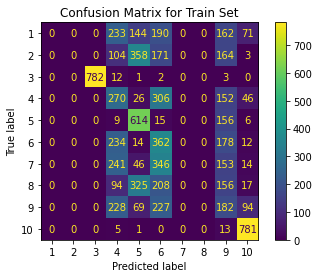

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

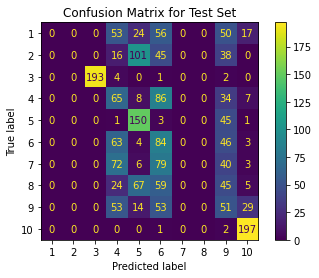

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()